In [51]:
import gzip
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as lines
import time
import operator 
from operator import itemgetter
import struct
import sklearn
from sklearn import neighbors, metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

# Read MNIST data:
There are many [ways](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python) you can read the MNIST data. Here is a [way](https://stackoverflow.com/a/62781370) to read all the information.

Train data (X) size: (60000, 28, 28), and labels (Y) size: (60000,)
Test data (X) size: (10000, 28, 28), and labels (Y) size: (10000,)


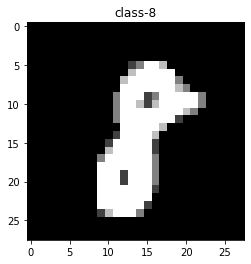

Train image 19541-th sample 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  64 128 255 255 191
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 191 255 255 255 255
  255   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 191 255 255 255 255 255
  255 128   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  

In [43]:
def read_images(filename):
    """Read MNIST images"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        
    return images

def read_labels(filename):
    """Read MNIST labels"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
    return labels
#C:/Users/Ujjwa/OneDrive/Desktop/BDA/Semester 2/Machine Learning/Class/Assignments/Assignment 1

dataset_path = 'C:/Users/Ujjwa/OneDrive/Desktop/BDA/Semester 2/Machine Learning/Class/Assignments/Assignment 1/'

train_image_filename = ''.join([dataset_path, 'train-images-idx3-ubyte.gz'])
train_label_filename = ''.join([dataset_path, 'train-labels-idx1-ubyte.gz'])

test_image_filename = ''.join([dataset_path, 't10k-images-idx3-ubyte.gz'])
test_label_filename = ''.join([dataset_path, 't10k-labels-idx1-ubyte.gz'])

train_images = read_images(train_image_filename)
train_labels = read_labels(train_label_filename)
print('Train data (X) size: {}, and labels (Y) size: {}' .format(train_images.shape, train_labels.shape))

test_images = read_images(test_image_filename)
test_labels = read_labels(test_label_filename)
print('Test data (X) size: {}, and labels (Y) size: {}' .format(test_images.shape, test_labels.shape))

rand_ids = np.random.choice(train_images.shape[0])
plt.imshow(train_images[rand_ids, :, :], cmap='gray')
plt.title('class-'+str(train_labels[rand_ids]))
plt.show()

print('Train image {}-th sample ' .format(rand_ids))
print(train_images[rand_ids, :, :])



### KNN Trial

In [44]:
# Training Data 
print(train_images.shape) , print(train_labels.shape)
# Testing Data
print(test_images.shape) , print(test_labels)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
[7 2 1 ... 4 5 6]


(None, None)

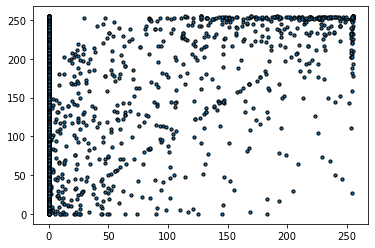

In [45]:
plt.figure()
plt.scatter(train_images[:,1] , train_images[:,2], edgecolor = 'k', s = 10)

In [52]:
y_train_df = pd.DataFrame(data = train_labels, columns = ['class'])
y_test_df = pd.DataFrame(data = test_labels, columns = ['class'])

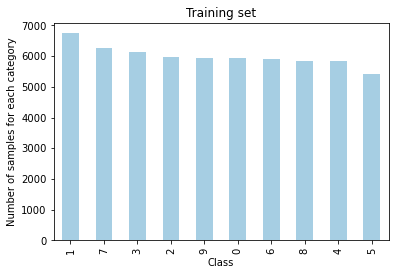

In [53]:
y_train_df['class'].value_counts().plot(kind = 'bar', colormap = 'Paired')
plt.xlabel('Class')
plt.ylabel('Number of samples for each category')
plt.title('Training set')
plt.show()

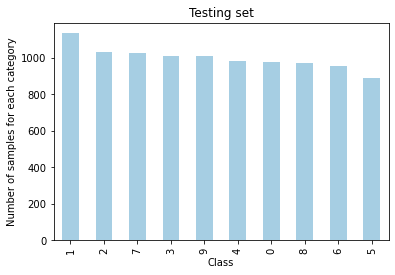

In [54]:
y_test_df['class'].value_counts().plot(kind = 'bar', colormap = 'Paired')
plt.xlabel('Class')
plt.ylabel('Number of samples for each category')
plt.title('Testing set')
plt.show()

In [55]:
# calculate euclidean distance
def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

In [72]:
# a list to store euclidean distance
train_distance_list = []
# a list to store index
train_ind_counter = []
# a list with all the K values
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19,21]
# creating a list of list for storing the predictions for each value of K
train_pred_lists = [[] for _ in range(len(k_values))]

# training the knn model
# iterating through the training set
for i in range(0,6000):
    train_vec_one = train_df.iloc[i]
    # iterating through the training set
    for j in range(0,6000):
        train_vec = train_df.iloc[j]
        # calculate euclidean distance by calling function dist
        euclidean_dist = dist(train_vec_one,train_vec)
        train_distance_list.append(euclidean_dist)
        # increment the index
        train_ind_counter.append(j)
    
    # dictionary to store all the results
    d = {'index':train_ind_counter, 'distance': train_distance_list}
    # convert dictionary to dataframe
    df = pd.DataFrame(d, columns = ['index', 'distance'])
    # sort in ascending order by euclidean distance
    df_sorted = df.sort_values(by = 'distance')

    # iterate through each value of K
    for K in range(len(k_values)):
        index_list = list(df_sorted['index'][:k_values[K]])
        distance = list(df_sorted['distance'][:k_values[K]])
        res_list = [train_labels[i] for i in index_list]
        # now get the count of the max class in result list
        pred_value = max(res_list,key=res_list.count)
        # storing every prediction for K in respective list
        train_pred_lists[K].append(pred_value)
    
    # reinitialize the list
    train_ind_counter = []
    train_distance_list = []

KeyboardInterrupt: 

In [ ]:
############################################################################################################################

In [ ]:
############################################################################################################################

### Shuffling Index

In [58]:
shuffle_index = np.random.permutation(60000)

In [59]:
train_images = train_images[shuffle_index]
train_labels = train_labels[shuffle_index]

### Lets plot some Random Digit

In [60]:
# Selecting a random digit
random_number = np.random.randint(0,59999)
r_d = train_images[random_number] 

In [61]:
# Reshape it to 28 x 28
r_d_image= r_d.reshape(28,28)

5


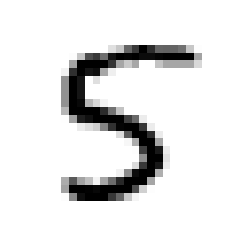

In [62]:
#Ploting the image
plt.imshow(r_d_image,cmap=matplotlib.cm.binary,interpolation='nearest')
plt.axis('off')
print(train_labels[random_number])

# Extract 20% data from the training data as a validation set. <font color='red'>Please do not use some standard function from scikit-learn or others!</font>

In [63]:
#train_images_20 = train_images[:int(len(train_images)*0.2)]
#train_labels_20 = train_labels[:int(len(train_images)*0.2)]

In [64]:
type(train_images)

numpy.ndarray

In [65]:
type(train_labels)

numpy.ndarray

In [66]:
len(train_images)

60000

In [67]:
train_flat = train_images.reshape(len(train_images),28*28)

In [68]:
train_flat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [69]:
train_df = pd.DataFrame(train_flat)

In [70]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
val_df = train_df.iloc[48000:]

In [55]:
train_img = train_df.iloc[:48000] # Later Change it

In [56]:
val_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
48000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
train_img

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
val_lab = train_labels[48000:]

In [71]:
# 

In [74]:
val_lab

array([2, 9, 5, ..., 1, 9, 4], dtype=uint8)

In [75]:
train_lab = train_labels[:48000]

In [76]:
train_lab

array([6, 3, 9, ..., 3, 3, 9], dtype=uint8)

# Implement k-NN classification rule/algorithm, we have discussed in our class. <font color='red'>Please do not use some standard function from scikit-learn or others!</font>

In [77]:
# Accurace functon
def accuracy(a, b):
    c = np.array(a) == np.array(b)
    return np.sum(c)/len(a)

In [78]:
# Your k-NN algorithm script/code 


In [79]:
# Predictions for all k
def predictions(data, size, fun):
    record = {}
    sl_df = data.iloc[:size]

    for k in range(1, 26, 2):
        record[k] = []

    for jj in sl_df.index:
        x = sl_df.loc[jj]
        tem = train_img.apply(fun, b = x, axis = 1)
        tem_df = pd.DataFrame(tem)
        tem_df["label"] = train_lab
        tem_sort = tem_df.sort_values(by = [0])
        for k in range(1, 26, 2):
            tem_k = tem_sort.iloc[0:k]
            y = tem_k.value_counts("label").index[0]
            record[k].append(y)
    print("Col indexes are values of k, values along col are predictions")
    return pd.DataFrame(record)
    

In [80]:
# predictions for a single k
def single_pred(a, fun, k):
    x = a
    tem = train_img.apply(fun, b = x, axis = 1)
    tem_df = pd.DataFrame(tem)
    tem_df["label"] = train_lab
    tem_sort = tem_df.sort_values(by = [0])
    tem_k = tem_sort.iloc[0:k]
    y = tem_k.value_counts("label").index[0]
    return y

def prediction_k(data, fun, k):
    record = []
    sl_df = data
    if isinstance(sl_df, pd.DataFrame):
        for jj in sl_df.index:
            x = sl_df.loc[jj]
            tem = train_img.apply(fun, b = x, axis = 1)
            tem_df = pd.DataFrame(tem)
            tem_df["label"] = train_lab
            tem_sort = tem_df.sort_values(by = [0])
            tem_k = tem_sort.iloc[0:k]
            y = tem_k.value_counts("label").index[0]
            record.append(y)
        return record
    else:
        return single_pred(sl_df, fun, k)
    

In [81]:
# calculate euclidean distance
def eucl_dist(a,b):   
    return np.sqrt(np.sum((a-b)**2))

In [82]:
#e_dist(train_images_20[0],train_images_20[0])

In [83]:
'''
# a list to store euclidean distance
train_distance_list = []
# a list to store index
train_ind_counter = []
# a list with all the K values
k_values = [1, 3, 5]
# creating a list of list for storing the predictions for each value of K
train_pred_lists = [[] for _ in range(len(k_values))]

# training the knn model
# iterating through the training set
for i in range(0,11599):
    train_vec_one = train_images_20[i]
    # iterating through the training set
    for j in range(0,6000):
        train_vec = train_images_20[j]
        # calculate euclidean distance by calling function dist
        euclidean_dist = dist(train_vec_one,train_vec)
        train_distance_list.append(euclidean_dist)
        # increment the index
        train_ind_counter.append(j)

    # dictionary to store all the results
    d = {'index':train_ind_counter, 'distance': train_distance_list}
    # convert dictionary to dataframe
    df = pd.DataFrame(d, columns = ['index', 'distance'])
    # sort in ascending order by euclidean distance
    df_sorted = df.sort_values(by = 'distance')

    # iterate through each value of K
    for K in range(len(k_values)):
        index_list = list(df_sorted['index'][:k_values[K]])
        distance = list(df_sorted['distance'][:k_values[K]])
        res_list = [y_train[i] for i in index_list]
        # now get the count of the max class in result list
        pred_value = max(res_list,key=res_list.count)
        # storing every prediction for K in respective list
        train_pred_lists[K].append(pred_value)
    
    # reinitialize the list
    train_ind_counter = []
    train_distance_list = []
'''

"\n# a list to store euclidean distance\ntrain_distance_list = []\n# a list to store index\ntrain_ind_counter = []\n# a list with all the K values\nk_values = [1, 3, 5]\n# creating a list of list for storing the predictions for each value of K\ntrain_pred_lists = [[] for _ in range(len(k_values))]\n\n# training the knn model\n# iterating through the training set\nfor i in range(0,11599):\n    train_vec_one = train_images_20[i]\n    # iterating through the training set\n    for j in range(0,6000):\n        train_vec = train_images_20[j]\n        # calculate euclidean distance by calling function dist\n        euclidean_dist = dist(train_vec_one,train_vec)\n        train_distance_list.append(euclidean_dist)\n        # increment the index\n        train_ind_counter.append(j)\n\n    # dictionary to store all the results\n    d = {'index':train_ind_counter, 'distance': train_distance_list}\n    # convert dictionary to dataframe\n    df = pd.DataFrame(d, columns = ['index', 'distance'])\n   

In [84]:
samp_size = 5

In [85]:
%%time
# for euclidean
pre_eu = predictions(val_df, samp_size, eucl_dist)
pre_eu

Col indexes are values of k, values along col are predictions
Wall time: 38.6 s


,1,3,5,7,9,11,13,15,17,19,21,23,25
0,3,3,3,2,2,2,2,4,3,3,3,3,3
1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,4,1,1,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1


In [86]:
acc_eu = pre_eu.apply(accuracy, b = val_lab[:samp_size]).sort_values(ascending=False)
acc_eu

7     0.6
9     0.6
11    0.6
13    0.6
1     0.4
3     0.4
5     0.4
15    0.4
17    0.4
19    0.4
21    0.4
23    0.4
25    0.4
dtype: float64

In [87]:
# Most Efficient K
eu_k = acc_eu.index[0]
eu_k

7

In [88]:
# Highest accuracy
eu_val = acc_eu.values[0]
eu_val

0.6

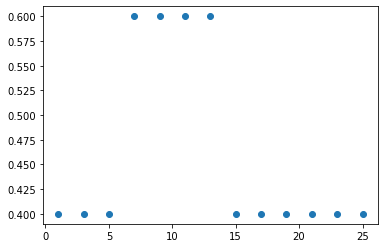

In [89]:
plt.scatter(acc_eu.index, acc_eu.values)

Test Data Set

In [90]:
sample_size = 10

In [91]:
#
test_imgs = pd.DataFrame(test_images.reshape(10000,28*28))

In [92]:
%%time
# Euclidean
prp_eu = prediction_k(test_imgs.iloc[:sample_size], eucl_dist, eu_k)
prp_eu

Wall time: 1min 17s


[7, 1, 1, 0, 0, 1, 7, 7, 0, 1]

In [93]:
# Confusion Matrix Euclidean
pd.crosstab(np.array(prp_eu), test_labels[:sample_size])

col_0,0,1,2,4,5,7,9
row_0,,,,,,,
0,1,0,0,1,1,0,0
1,0,2,1,0,0,0,1
7,0,0,0,1,0,1,1


In [94]:
# Accuracy of this test data for this k
accuracy(prp_eu, test_labels[:sample_size])

0.4